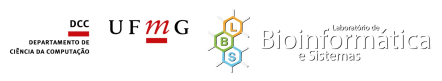

Federal University of Minas Gerais

Department of Computer Science

[Bioinformatics and Systems Laboratory](http://bioinfo.dcc.ufmg.br/)

Authors: Lucas Moraes, Diego Mariano and Prof. Dr. Raquel Cardoso de Melo-Minardi

In [ ]:
'''
This source code, developed using PyTorch, aims to fine-tune the transformer model for the following specific tasks:
(i) classifying protein-peptide interfaces based on sequence similarities; and (ii) classifying protein-peptide
interfaces according to similarities in the peptide's role and function.. This code has been used in the academic
and research context of the Department of Computer Science at the Federal University of Minas Gerais, specifically
in the Bioinformatics and Systems Laboratory.
'''



---



In [ ]:
!python --version

Python 3.10.12



> Importação de bibliotecas


In [ ]:
import torch
torch.__version__

'2.2.1+cu121'

In [ ]:
# Importing necessary libraries
import torchvision

from torch import nn
from torchvision import datasets, transforms

> Sync with Drive

In [ ]:
# Mount Google Drive to access dataset directories and the model save path

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define base directory for reference

BASE_DIR = "/content/drive/My Drive/"

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)


> Create Datasets and DataLoaders


In [ ]:
import os

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Image size
IMG_SIZE = 224

# Batch size
BATCH_SIZE = 64

# Patch size
PATCH_SIZE = 16

In [ ]:
# Define directories for training, validation, and testing datasets

train_dir = '/content/drive/My Drive/Dataset/Variants/Training'
validation_dir = '/content/drive/My Drive/Dataset/Variants/Validation'
test_dir = '/content/drive/My Drive/Dataset/Variants/P1'
save_dir = '/content/drive/My Drive/Models/'

In [ ]:
NUM_WORKERS = os.cpu_count()

In [ ]:
def create_data_loaders(train_dir:str, validation_dir:str, test_dir:str, batch_size:int, transform:transforms.Compose, num_workers:int=NUM_WORKERS):

  """
    Create PyTorch data loaders for the datasets.

    Parameters:
    - train_dir: Path to the training data directory.
    - validation_dir: Path to the validation data directory.
    - test_dir: Path to the test data directory.
    - batch_size: Number of images to process in a batch.
    - transform: Image transformations to apply.
    - num_workers: Number of subprocesses to use for data loading.
  """

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

  validation_data = datasets.ImageFolder(validation_dir, transform=transform)
  validation_data_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

  test_data = datasets.ImageFolder(test_dir, transform=transform)
  test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

  class_names = train_data.classes

  return train_data_loader, validation_data_loader, test_data_loader, class_names

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
  ])

In [ ]:
# Create dataloaders for the datasets
train_dataloader, test_dataloader, class_names = create_data_loaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    transform=transform
  )

Resizing the distance map

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)



> Pre-trained Model



In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Load a pre-trained model
pretrained_weights = torchvision.models.ViT_H_14_Weights.IMAGENET1K_SWAG_LINEAR_V1
pretrained_model = torchvision.models.vit_h_14(weights=pretrained_weights).to(device)
for param in pretrained_model.parameters():
  param.requires_grad = False

In [ ]:
pretrained_transforms = pretrained_weights.transforms()
print(pretrained_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
train_dataloader_pretrained, validation_dataloader_pretrained, test_dataloader_pretrained, class_names = create_data_loaders(train_dir=train_dir,
                                                                                                                              validation_dir=validation_dir,
                                                                                                                              test_dir=test_dir,
                                                                                                                              transform=pretrained_transforms,
                                                                                                                              batch_size=64)

In [ ]:
# Update the classifier head of the pre-trained model
pretrained_model.heads = nn.Sequential(nn.Linear(in_features=1280, out_features=len(class_names))).to(device)

In [ ]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_model.parameters(),
                             lr=1E-4)
loss_fn = torch.nn.CrossEntropyLoss()


> Hyperparameter optimization


In [ ]:
epochs = 50
greater_accuracy = 0.0

for epoch in range(epochs):
  pretrained_model.train()  # Set model to training mode
  for i, (inputs, labels) in enumerate(train_dataloader_pretrained):
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = pretrained_model(inputs)
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}], Loss: {loss.item():.4f}')

  pretrained_model.eval()  # Set model to evaluation mode
  with torch.no_grad():
    correct_predictions = 0
    total = 0
    for inputs, labels in validation_dataloader_pretrained:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = pretrained_model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct_predictions += (predicted == labels).sum().item()

    validation_accuracy = 100 * correct_predictions / total
    print(f'Accuracy of the model on the validation images: {validation_accuracy:.2f} %')

    if validation_accuracy >= greater_accuracy:
      greater_accuracy = validation_accuracy
      torch.save(pretrained_model.state_dict(), os.path.join(save_dir, f"pretrained_model_epoch{epoch+1}_acc{round(greater_accuracy)}.pth"))
      print(f"Pretrained model saved with accuracy: {greater_accuracy:.2f}%")

> Fine tuning

In [ ]:
epochs = 50
min_loss = torch.inf

for epoch in range(epochs):
    pretrained_model.train()  # Set model to training mode
    epoch_losses = []

    for i, (inputs, labels) in enumerate(train_dataloader_pretrained):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = pretrained_model(inputs)
        loss = loss_fn(outputs, labels)
        epoch_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}], Loss: {loss.item():.4f}')

    epoch_loss = sum(epoch_losses) / len(epoch_losses)  # Calculate average loss for the epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Average Loss: {epoch_loss:.4f}")

    # Save the model if the average loss of the current epoch is less than min_loss
    if epoch_loss < min_loss:
        print(f"Epoch {epoch + 1}: Loss improved from {min_loss:.4f} to {epoch_loss:.4f}. Saving model...")
        min_loss = epoch_loss  # Update min_loss to the new lower value
        torch.save(pretrained_model.state_dict(), os.path.join(save_dir, f"pretrained_model_epoch{epoch + 1}_loss{epoch_loss:.4f}.pth"))

In [ ]:
torch.save(pretrained_model.state_dict(), os.path.join(save_dir, f"vipec_20240325_sequences_propedia_v2-3_fold1.pth"))



> Load the saved model state dictionary



In [ ]:
# Load the saved model state dictionary
pretrained_model.load_state_dict(torch.load(os.path.join(save_dir, f"vipec_20240325_sequences_propedia_v2-3_fold5.pth")))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device)

# Set the model to evaluation mode
pretrained_model.eval()


> Evaluation


In [ ]:
import numpy as np

num_classes = 5  # Classes

# Initialize confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

with torch.no_grad():
  for images, labels in test_dataloader_pretrained:
    images, labels = images.to(device), labels.to(device)
    outputs = pretrained_model(images)
    _, predictions = torch.max(outputs, 1)

    # Update confusion matrix
    for label, prediction in zip(labels, predictions):
        confusion_matrix[label.item(), prediction.item()] += 1

print("Confusion Matrix:\n", confusion_matrix)

In [ ]:
# Calculate accuracy per class from the confusion matrix
for i in range(num_classes):
    correct = confusion_matrix[i, i]
    total = confusion_matrix[i].sum()
    if total > 0:
        print(f'Accuracy for class {i}: {100 * correct / total:.2f}%')
    else:
        print(f'Class {i} has no samples')

# Overall accuracy
overall_accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print(f'Overall Accuracy: {100 * overall_accuracy:.2f}%')

In [ ]:
import numpy as np

def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score[i] = 2*precision[i]*recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    # Macro average
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    # Micro average (overall)
    tp_total = np.trace(confusion_matrix)
    fp_total = np.sum(confusion_matrix.sum(axis=0) - np.diag(confusion_matrix))
    fn_total = np.sum(confusion_matrix.sum(axis=1) - np.diag(confusion_matrix))

    micro_precision = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
    micro_recall = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
    micro_f1_score = 2*micro_precision*micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    return macro_precision, macro_recall, macro_f1_score, micro_precision, micro_recall, micro_f1_score

macro_precision, macro_recall, macro_f1_score, micro_precision, micro_recall, micro_f1_score = calculate_metrics(confusion_matrix)

print(f'Macro Precision: {macro_precision:.3f}')
print(f'Macro Recall: {macro_recall:.3f}')
print(f'Macro F1 Score: {macro_f1_score:.3f}')
print(f'Micro Precision: {micro_precision:.3f}')
print(f'Micro Recall: {micro_recall:.3f}')
print(f'Micro F1 Score: {micro_f1_score:.3f}')



---

